PROJECT

Deliverables:
    Notebook
    Documentation of the model
    Test that everything works well
Goals:
    Compare the environmental performance of 2 biobased insulation materials contrasted to a reference fossil insulation      material, applied     to buildings throught the prodution and end-of-life phases of the product.
Scope:
    The environmental performance is assessed through the climate change (CO2, Ch4, N2O), water use, and land use (area occupied) impacts
    LCIA method: 
    The assessment is performed for 50 years of lifetime of the buildings
    The EoL choices involve incineration, landfill, composting, and mulching (we are going to consider 2)
    Temporal scope:
    
Tools
    Github
    Temporalis
    Excel

  *How to consider the soil carbon sequestration/release/lost effect
  For croplands is shor, for forests is large


In [41]:
from bw_temporalis import easy_timedelta_distribution, easy_datetime_distribution, TemporalisLCA, Timeline, TemporalDistribution
from bw_temporalis.lcia import characterize_methane, characterize_co2

import bw2io as bi 
import bw2data as bd
import bw2calc as bc
import os               # to use "operating system dependent functionality"
import numpy as np      # "the fundamental package for scientific computing with Python"
import pandas as pd     # "high-performance, easy-to-use data structures and data analysis tools" for Python

In [42]:
import seaborn as sb

In [43]:
bd.Database('temporalis-example').write({
    # CO2 emission
    ('temporalis-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "temporalis code": "co2",
    },
    # EPS Production Process
    ('temporalis-example', 'EPS_production'): {
        'exchanges': [
            {
                'amount': 0.8,
                'input': ('temporalis-example', 'CO2'),
                'type': 'biosphere',
                'temporal_distribution': TemporalDistribution(
                    np.array([1], dtype='timedelta64[Y]'),  # Yearly time steps
                    np.array([1])
                ),
            },
        ],
        'name': 'EPS production',
        'type': 'process'
    },
    # EPS End-of-Life Process (Incineration)
    ('temporalis-example', 'EPS_Incineration'): {
        'exchanges': [
            {
                'amount': 0.15,
                'input': ('temporalis-example', 'CO2'),
                'temporal_distribution': TemporalDistribution(
                    np.array([50], dtype='timedelta64[Y]'),  # Emission delayed 50 years
                    np.array([1])
                ),
                'type': 'biosphere'
            },
        ],
        'name': 'EPS Incineration',
        'type': 'process'
    },
    # Functional Unit I
    ('temporalis-example', 'Functional Unit - EPS'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('temporalis-example', 'EPS_production'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'EPS_Incineration'),
                'type': 'technosphere'
            },
        ],
        'name': 'Functional Unit - EPS',
        'type': 'process'
    },

    # Bio Sequestration Process
    ('temporalis-example', 'BIO_sequestration'): {
        'exchanges': [
            {
                'amount': -1,
                'input': ('temporalis-example', 'CO2'),
                'type': 'biosphere',
                'temporal_distribution': TemporalDistribution(
                    np.array([1], dtype='timedelta64[Y]'),  # Yearly time steps
                    np.array([1])
                ),
            },
        ],
        'name': 'BIO sequestration',
        'type': 'process'
    },
    
    # Bio Production Process
    ('temporalis-example', 'BIO_production'): {
        'exchanges': [
            {
                'amount': 0.5,
                'input': ('temporalis-example', 'CO2'),
                'type': 'biosphere',
                'temporal_distribution': TemporalDistribution(
                    np.array([1], dtype='timedelta64[Y]'),  # Yearly time steps
                    np.array([1])
                ),
            },
        ],
        'name': 'BIO production',
        'type': 'process'
    },
    # BIO End-of-Life Process (Incineration)
    ('temporalis-example', 'BIO_incineration'): {
        'exchanges': [
            {
                'amount': 0.3,
                'input': ('temporalis-example', 'CO2'),
                'temporal_distribution': TemporalDistribution(
                    np.array([50], dtype='timedelta64[Y]'),  # Emission delayed 50 years
                    np.array([1])
                ),
                'type': 'biosphere'
            },
        ],
        'name': 'BIO incineration',
        'type': 'process'
    },
    # Functional Unit II
    ('temporalis-example', 'Functional Unit - BIO'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('temporalis-example', 'BIO_sequestration'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'BIO_production'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'BIO_incineration'),
                'type': 'technosphere'
            },
        ],
        'name': 'Functional Unit - BIO',
        'type': 'process'
    },
    
})
    

20:25:34 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████████████████████████████████████| 8/8 [00:00<00:00, 36832.53it/s]

20:25:34 [info     ] Vacuuming database            


In [45]:
bd.Method(("GWP", "example")).write([
    (('temporalis-example', "CO2"), 1)
])

In [56]:
def create_tlca_df(material):
    lca = bc.LCA({('temporalis-example', f'Functional Unit - {material}'): 1}, ("GWP", "example"))
    lca.lci()
    lca.lcia()

    tlca = TemporalisLCA(lca)

    tl = tlca.build_timeline()

    df = tl.build_dataframe()

    df[material] = df['amount'].cumsum()

    df = df.merge(
        bd.Database('temporalis-example').nodes_to_dataframe().rename(columns={'id': 'activity'}), 
        on='activity'
    )

    return df

df_eps = create_tlca_df('EPS')
df_bio = create_tlca_df('BIO')


Starting graph traversal
Calculation count: 2
Starting graph traversal
Calculation count: 3


In [57]:
df_eps

,date,amount,flow,activity,EPS,code,database,name,temporalis code,type
0,2025-11-15 01:20:48,0.80,1,2,0.80,EPS_production,temporalis-example,EPS production,NaN,processwithreferenceproduct
1,2074-11-14 22:31:36,0.15,1,3,0.95,EPS_Incineration,temporalis-example,EPS Incineration,NaN,processwithreferenceproduct


In [58]:
df_bio

,date,amount,flow,activity,BIO,code,database,name,temporalis code,type
0,2025-11-15 01:20:48,-1.0,1,5,-1.0,BIO_sequestration,temporalis-example,BIO sequestration,NaN,processwithreferenceproduct
1,2025-11-15 01:20:48,0.5,1,6,-0.5,BIO_production,temporalis-example,BIO production,NaN,processwithreferenceproduct
2,2074-11-14 22:31:36,0.3,1,7,-0.2,BIO_incineration,temporalis-example,BIO incineration,NaN,processwithreferenceproduct


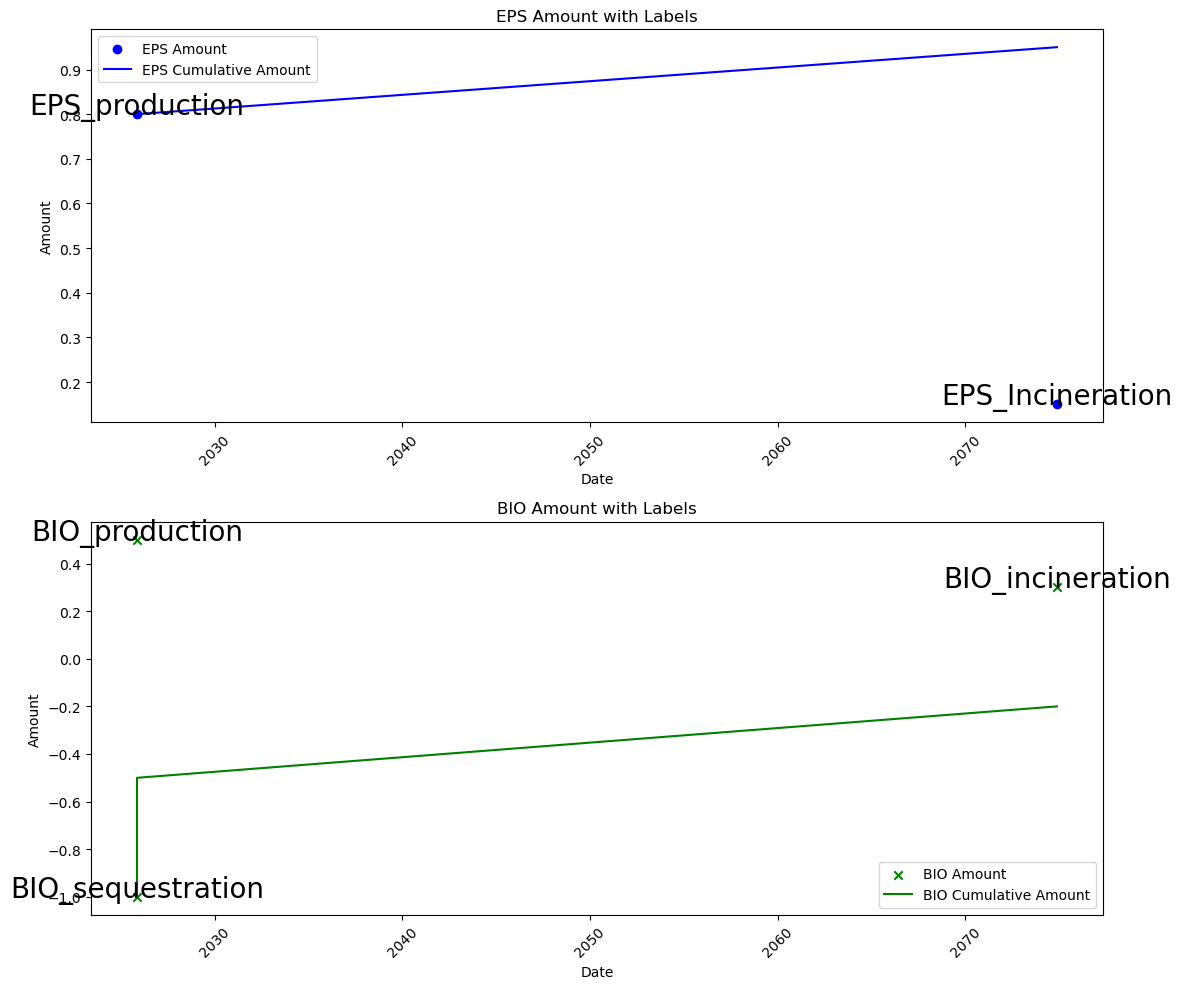

In [70]:
import matplotlib.pyplot as plt
# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# EPS Plot
ax1.scatter(df_eps['date'], df_eps['amount'], color='blue', marker='o', label='EPS Amount')
ax1.plot(df_eps['date'], df_eps['EPS'], label='EPS Cumulative Amount', color='blue', linestyle='-')
ax1.set_title('EPS Amount with Labels')
ax1.set_xlabel('Date')
ax1.set_ylabel('Amount')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Add labels for each point in EPS
for i, row in df_eps.iterrows():
    ax1.text(row['date'], row['amount'], row['code'], fontsize=20, ha='center')



# BIO Plot
ax2.scatter(df_bio['date'], df_bio['amount'], color='green', marker='x', label='BIO Amount')
ax2.plot(df_bio['date'], df_bio['BIO'], label='BIO Cumulative Amount', color='green', linestyle='-')
ax2.set_title('BIO Amount with Labels')
ax2.set_xlabel('Date')
ax2.set_ylabel('Amount')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# Add labels for each point in BIO
for i, row in df_bio.iterrows():
    ax2.text(row['date'], row['amount'], row['code'], fontsize=20, ha='center')

plt.tight_layout()
plt.show()

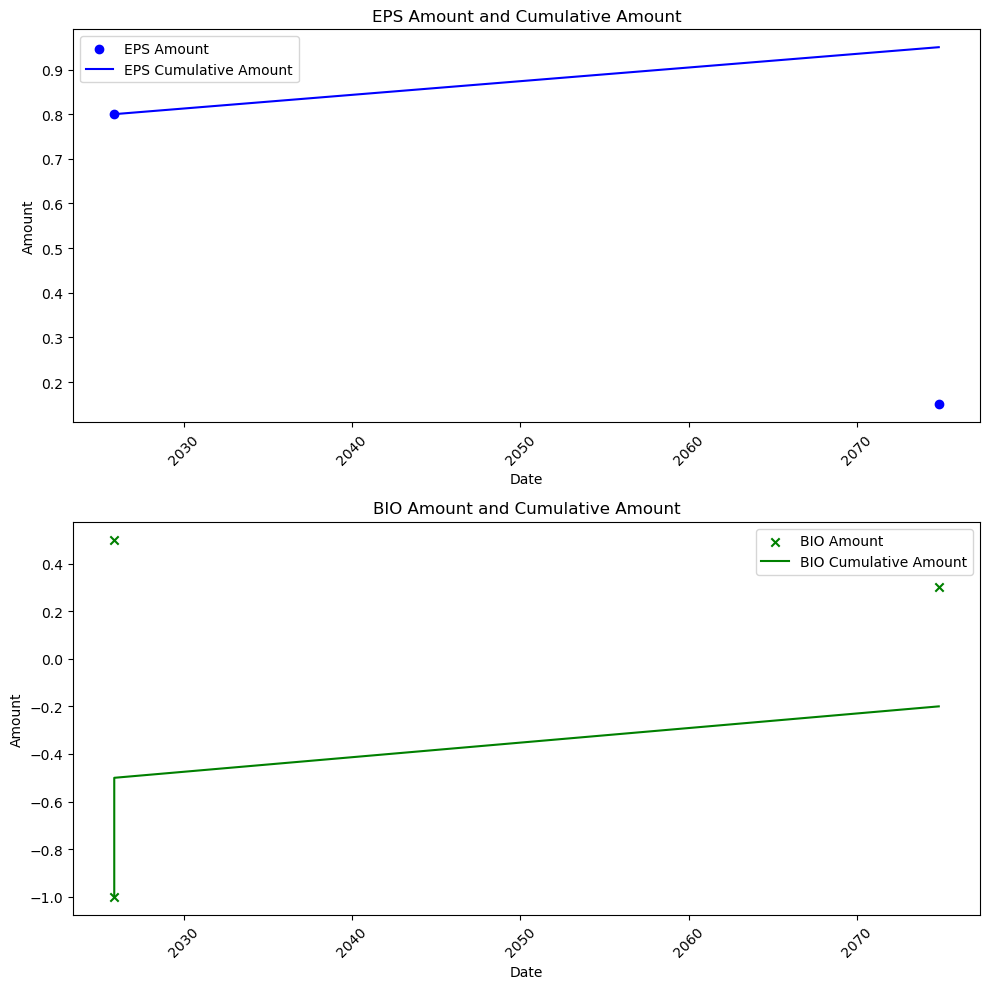

In [60]:

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))  # 2 rows, 1 column

# EPS Plot
ax1.scatter(df_eps['date'], df_eps['amount'], label='EPS Amount', color='blue', marker='o')
ax1.plot(df_eps['date'], df_eps['EPS'], label='EPS Cumulative Amount', color='blue', linestyle='-')
ax1.set_title('EPS Amount and Cumulative Amount')
ax1.set_xlabel('Date')
ax1.set_ylabel('Amount')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# BIO Plot
ax2.scatter(df_bio['date'], df_bio['amount'], label='BIO Amount', color='green', marker='x')
ax2.plot(df_bio['date'], df_bio['BIO'], label='BIO Cumulative Amount', color='green', linestyle='-')
ax2.set_title('BIO Amount and Cumulative Amount')
ax2.set_xlabel('Date')
ax2.set_ylabel('Amount')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()